In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 9,6
import seaborn as sb
sb.set()

In [2]:
import json
import requests
import datetime as dt

url = 'https://api.binance.com/api/v3/klines'
symbol = 'BTCUSDT'
interval = '1d'
start = str(int(dt.datetime(2023,8,1).timestamp()*1000))
end = str(int(dt.datetime(2024,6,1).timestamp()*1000))
par = {'symbol': symbol, 'interval': interval, 'startTime': start, 'endTime': end, 'limit': 1000}
btc = pd.DataFrame(json.loads(requests.get(url, params= par).text))
btc.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
btc.drop(columns=['open', 'high', 'low', 'volume', 'close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore'], inplace = True) #we will only use close price
btc.index = [dt.datetime.fromtimestamp(x/1000.0) for x in btc.datetime]
btc=btc.astype(float)
btc.head()

,datetime,close
2023-08-01 20:00:00,1.690934e+12,29186.01
2023-08-02 20:00:00,1.691021e+12,29193.64
2023-08-03 20:00:00,1.691107e+12,29113.99
2023-08-04 20:00:00,1.691194e+12,29072.13
2023-08-05 20:00:00,1.691280e+12,29088.42


adding all the data available (api only let me load max 1000 obs at once)

In [3]:
if: start = str(int(dt.datetime(2020,1,1).timestamp()*1000))
end = str(int(dt.datetime(2022,1,1).timestamp()*1000))
par = {'symbol': symbol, 'interval': interval, 'startTime': start, 'endTime': end, 'limit': 1000}
btc2 = pd.DataFrame(json.loads(requests.get(url, params= par).text))
btc2.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
btc2.drop(columns=['open', 'high', 'low', 'volume', 'close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore'], inplace = True) #we will only use close price
btc2.index = [dt.datetime.fromtimestamp(x/1000.0) for x in btc2.datetime]
btc2=btc2.astype(float)
btc2.head()

SyntaxError: invalid syntax (3398782225.py, line 1)

closing prices difference (return)

In [4]:
btc_return = round(np.log(btc.close).diff() * 100, 2)
btc_return.dropna(inplace = True)
btc_return.head()

2023-08-02 20:00:00    0.03
2023-08-03 20:00:00   -0.27
2023-08-04 20:00:00   -0.14
2023-08-05 20:00:00    0.06
2023-08-06 20:00:00    0.42
Name: close, dtype: float64

In [5]:
btc

,datetime,close
2023-08-01 20:00:00,1.690934e+12,29186.01
2023-08-02 20:00:00,1.691021e+12,29193.64
2023-08-03 20:00:00,1.691107e+12,29113.99
2023-08-04 20:00:00,1.691194e+12,29072.13
2023-08-05 20:00:00,1.691280e+12,29088.42
...,...,...
2024-05-27 20:00:00,1.716854e+12,68398.39
2024-05-28 20:00:00,1.716941e+12,67652.42
2024-05-29 20:00:00,1.717027e+12,68352.17
2024-05-30 20:00:00,1.717114e+12,67540.01


<Axes: >

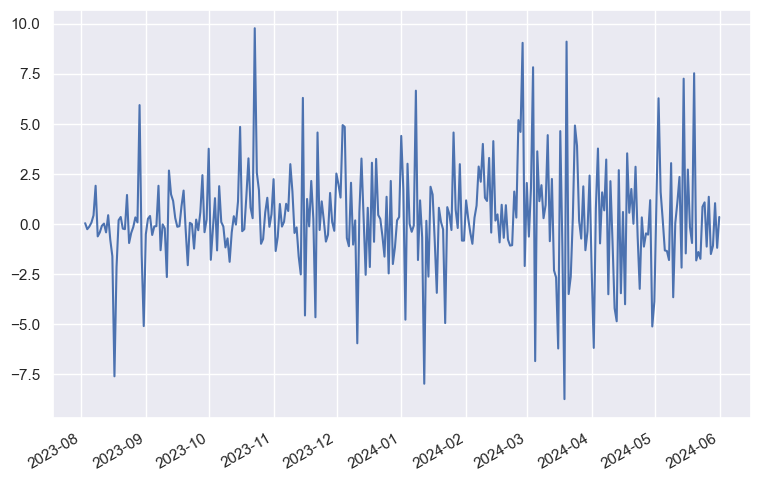

In [6]:
btc_return[-1500:].plot()

estadísticos

In [7]:
btc_return.describe()

count    304.000000
mean       0.277237
std        2.592049
min       -8.760000
25%       -0.892500
50%        0.095000
75%        1.395000
max        9.770000
Name: close, dtype: float64

this look kinda weird to run regression lol

In [8]:
from scipy import stats

In [9]:
n, minmax, mean, var, skew, kurt = stats.describe(btc_return)
mini, maxi = minmax
std = var**0.5

In [10]:
print(minmax)
print(std)

(-8.76, 9.77)
2.59204920332033


for comparasion, i'll generate random numbers that DO follow a normal distribution

In [11]:
from scipy.stats import norm

In [12]:
x = norm.rvs(mean, std, n)

In [13]:
stats.describe(x)

DescribeResult(nobs=304, minmax=(-7.162239181393087, 7.02287430416735), mean=-0.06693959345351119, variance=7.306735759356234, skewness=-0.0313465755223787, kurtosis=-0.2027436516094041)

(array([ 5.,  6.,  8.,  9., 27., 41., 37., 46., 34., 28., 26., 15., 14.,
         6.,  2.]),
 array([-7.16223918, -6.21656495, -5.27089072, -4.32521648, -3.37954225,
        -2.43386802, -1.48819379, -0.54251955,  0.40315468,  1.34882891,
         2.29450314,  3.24017737,  4.18585161,  5.13152584,  6.07720007,
         7.0228743 ]),
 <BarContainer object of 15 artists>)

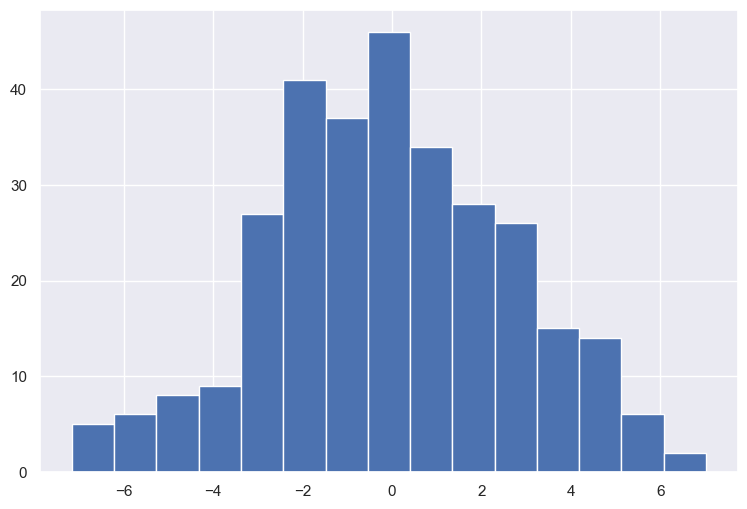

In [14]:
plt.hist(x, bins=15)

now, our data

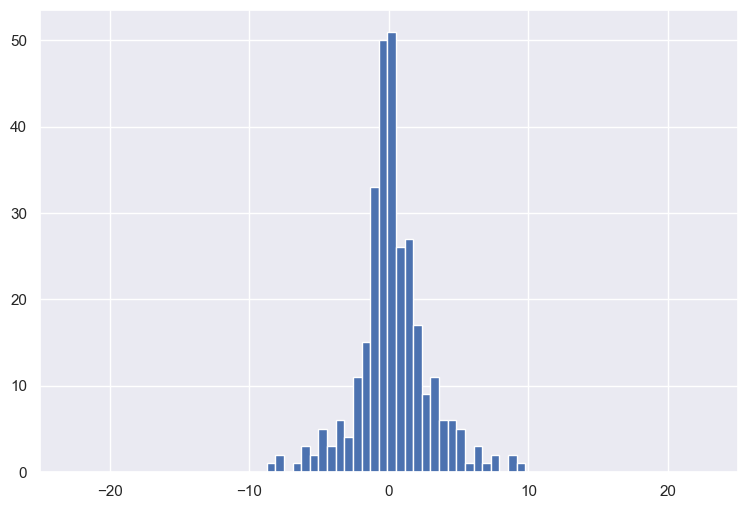

In [15]:
plt.hist(btc_return, bins=30)
plt.xlim(-25,25);

looks like it isn't normal distributed

testing if price change is normally distributed
-using null hypothesis H0: the sample is drawn from a population where the underlying kurtosis is that of a normally distributed variable / and if we have enough evidence we gonna reject that

In [16]:
x_test = stats.kurtosistest(x)
btc_test = stats.kurtosistest(btc_return)
print(f'{"      Test statistic":20}{"p-value":>15}')
print(f'{" "*5}{"-"* 30}')
print(f"x:{x_test[0]:>17.2f}{x_test[1]:16.4f}")
print(f"btc: {btc_test[0]:13.2f}{btc_test[1]:16.4f}")

      Test statistic        p-value
     ------------------------------
x:            -0.62          0.5332
btc:          4.46          0.0000


p-value of btc isn't 0 (it is just very smol) -> in the standar case we using 95% conf level, then p-value < alpha -> the alt hypothesis does give us significantly data to reject null hypothesis

(x data with a 0.54 p-value -> if we reject the null hip, there's around a 54% chances that we are making a mistake by doing that)

i.e., our data (btc close price) doesnt follow a normal distribution

plotting an histogram of price changes with normal curve overlay (on our data)

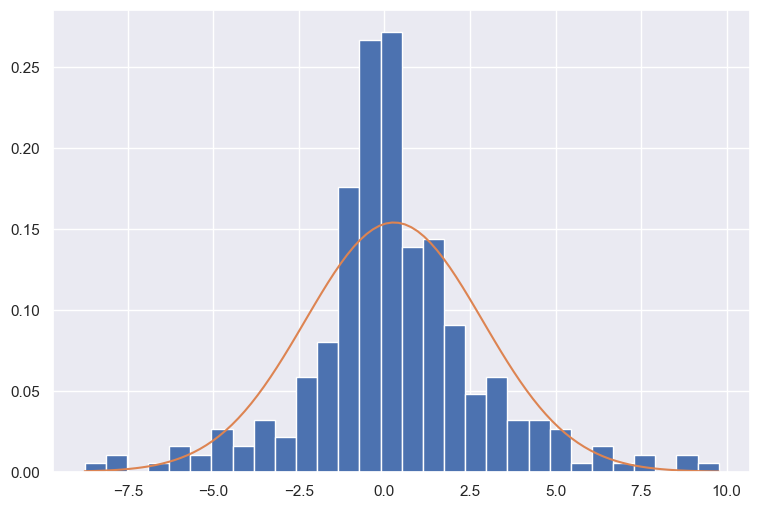

In [18]:
plt.hist(btc_return, bins=30, edgecolor='w', density=True)
data = np.linspace(mini, maxi, 100)
plt.plot(data, norm.pdf(data, mean, std))

comparing with x (normal distr created data)

(-20.0, 20.0)

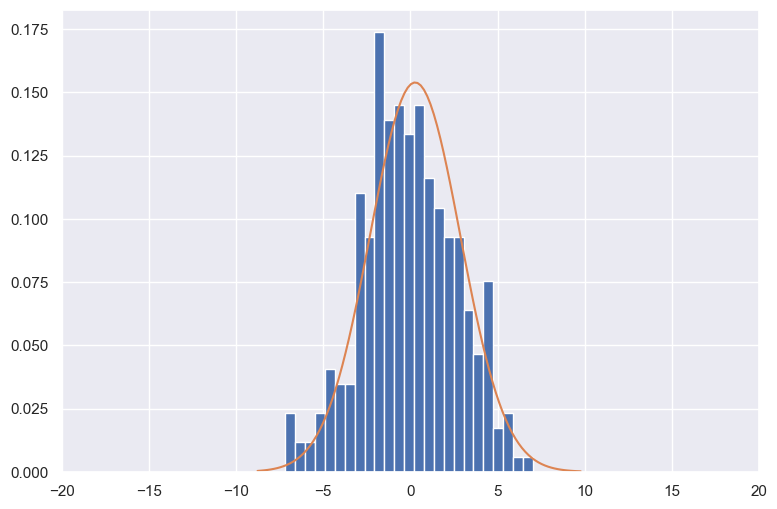

In [19]:
plt.hist(x, bins=25, density=True)
b = np.linspace(mini, maxi, 100)
plt.plot(b, stats.norm.pdf(b, mean, std))
plt.xlim(-20,20)

now, is daily price change significantly different from zero?

In [20]:
#simple hypothesis test 
#when using ttest with >122 data, is almost the same as z test
stats.ttest_1samp(btc_return.sample(360), 0, alternative='two-sided')

ValueError: Cannot take a larger sample than population when 'replace=False'

p-value > 0.05 (in the 'standar' case that we are using 95% confidence level, i.e., we accept the null hypothesis)

can price movement be described as a random walk?

In [21]:
#creating price lags
btc_close = pd.DataFrame(btc.close, columns=['close'])
btc_close['lag_1'] = btc_close.close.shift(1)
btc_close['lag_2'] = btc_close.close.shift(2)
btc_close.dropna(inplace = True)
btc_close.head()

,close,lag_1,lag_2
2023-08-03 20:00:00,29113.99,29193.64,29186.01
2023-08-04 20:00:00,29072.13,29113.99,29193.64
2023-08-05 20:00:00,29088.42,29072.13,29113.99
2023-08-06 20:00:00,29211.06,29088.42,29072.13
2023-08-07 20:00:00,29770.42,29211.06,29088.42


now, fitting a linear model (i'll use linear regression for this one)

In [22]:
lr = np.linalg.lstsq(btc_close[['lag_1', 'lag_2']], btc_close.close, rcond=None)[0]
lr

array([0.84030722, 0.16243094])

adding some price lags

In [23]:
btc_close['predict'] = np.dot(btc_close[['lag_1', 'lag_2']], lr)
btc_close.head()

,close,lag_1,lag_2,predict
2023-08-03 20:00:00,29113.99,29193.64,29186.01,29272.337660
2023-08-04 20:00:00,29072.13,29113.99,29193.64,29206.646538
2023-08-05 20:00:00,29088.42,29072.13,29113.99,29158.533653
2023-08-06 20:00:00,29211.06,29088.42,29072.13,29165.422898
2023-08-07 20:00:00,29770.42,29211.06,29088.42,29271.124176


prediction graph

<Axes: >

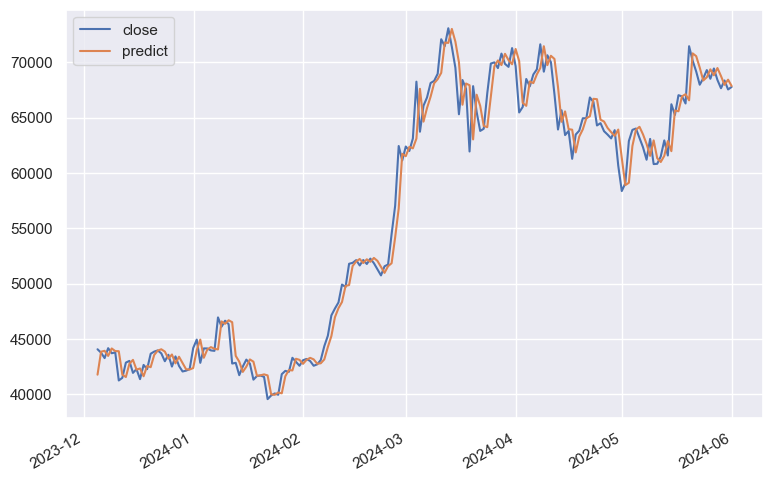

In [24]:
btc_close.iloc[-180:][['close','predict']].plot()

accuracy of predictons

In [25]:
btc_close['difference'] = btc_close['predict'] - btc_close['close']
btc_close.head()

,close,lag_1,lag_2,predict,difference
2023-08-03 20:00:00,29113.99,29193.64,29186.01,29272.337660,158.347660
2023-08-04 20:00:00,29072.13,29113.99,29193.64,29206.646538,134.516538
2023-08-05 20:00:00,29088.42,29072.13,29113.99,29158.533653,70.113653
2023-08-06 20:00:00,29211.06,29088.42,29072.13,29165.422898,-45.637102
2023-08-07 20:00:00,29770.42,29211.06,29088.42,29271.124176,-499.295824


<Axes: >

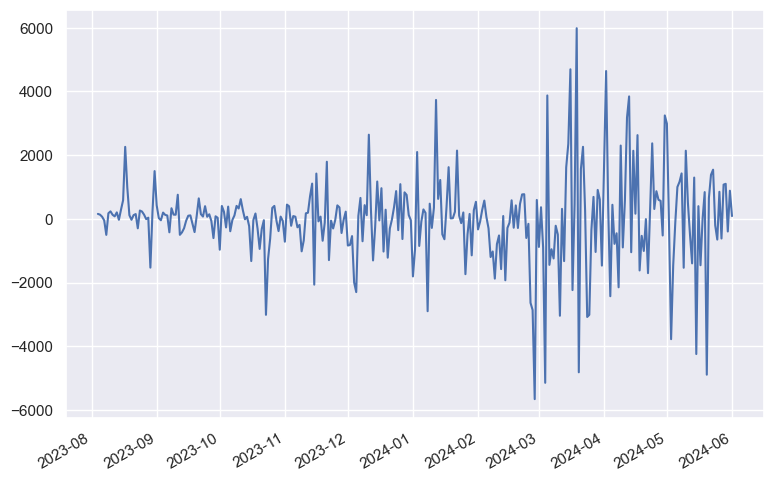

In [26]:
btc_close['difference'].plot()

In [27]:
btc_close['% error'] = (abs(btc_close['difference']*100)) / btc_close['close']
btc_close.head()

,close,lag_1,lag_2,predict,difference,% error
2023-08-03 20:00:00,29113.99,29193.64,29186.01,29272.337660,158.347660,0.543889
2023-08-04 20:00:00,29072.13,29113.99,29193.64,29206.646538,134.516538,0.462699
2023-08-05 20:00:00,29088.42,29072.13,29113.99,29158.533653,70.113653,0.241036
2023-08-06 20:00:00,29211.06,29088.42,29072.13,29165.422898,-45.637102,0.156232
2023-08-07 20:00:00,29770.42,29211.06,29088.42,29271.124176,-499.295824,1.677154


<Axes: >

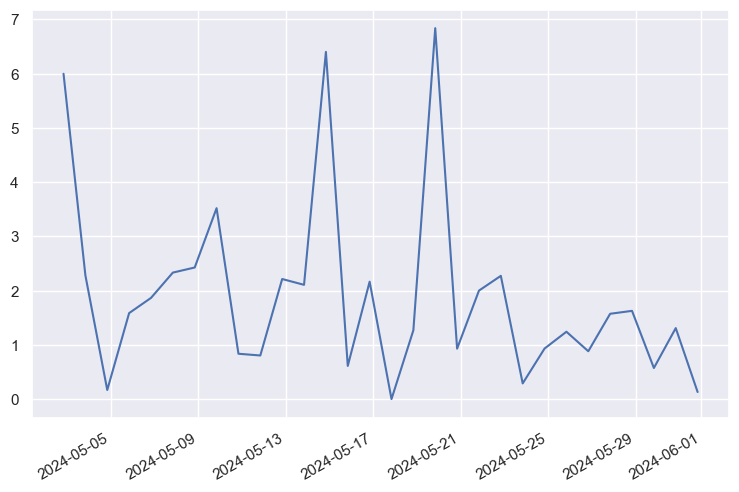

In [28]:
btc_close.iloc[-30:]['% error'].plot()

In [29]:
btc_close.iloc[-1]

close         67766.850000
lag_1         67540.010000
lag_2         68352.170000
predict       67856.865617
difference       90.015617
% error           0.132831
Name: 2024-05-31 20:00:00, dtype: float64

In [30]:
btc_close.iloc[-2:]

,close,lag_1,lag_2,predict,difference,% error
2024-05-30 20:00:00,67540.01,68352.17,67652.42,68425.668477,885.658477,1.311309
2024-05-31 20:00:00,67766.85,67540.01,68352.17,67856.865617,90.015617,0.132831
